# A Period - Magnitude Relation in Cepheid Stars

* Cepheids are stars whose brightness oscillates with a stable period that appears to be strongly correlated with their luminosity (or absolute magnitude).


* A lot of _monitoring_ data - repeated imaging and subsequent "photometry" of the star - can provide a measurement of the absolute magnitude (if we know the distance to it's host galaxy) and the period of the oscillation.


* Let's look at some Cepheid measurements reported by [Riess et al (2011)](Riess et al., 2011, ApJ, 730, 119).  Like the correlation function summaries, they are in the form of datapoints with error bars, where it is not clear how those error bars were derived (or what they mean).


* Our goal is to infer the parameters of a simple relationship between Cepheid period and, in the first instance, apparent magnitude.

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) 

## A Look at Each Host Galaxy's Cepheids

Let's read in all the data, and look at each galaxy's Cepheid measurements separately. Instead of using `pandas`, we'll write our own simple data structure, and give it a custom plotting method so we can compare the different host galaxies' datasets.

In [3]:
# First, we need to know what's in the data file.

!head -15 R11ceph.dat

#id gal m merr P logO_H bias
#this is a processed version of the R11 cepheid data
#see Riess et al., 2011, ApJ, 730, 119, Table 2
#id is the ID of the cepheid
#gal is the NGC hist number
#mags m are computed using m = F160W - 0.41*(V_I)
#mag errs are just those in the F160W mags
#errors in V-I were not given in R11
#period P is in days
#errors in the Period were not given
#logO_H is actual log[O/H], not 12 + log[O/H] as in R11
#bias is the crwoding bias *already applied* by R11
#cepheid with id 102255 was excluded since its magnitude error is 99.0
27185 4536 24.512300 0.310000 13.000000 -3.460000 0.130000
42353 4536 25.990700 0.740000 13.070000 -3.030000 0.370000


In [4]:
class Cepheids(object):
    
    def __init__(self,filename):
        # Read in the data and store it in this master array:
        self.data = np.loadtxt(filename)
        self.hosts = self.data[:,1].astype('int').astype('str')
        # We'll need the plotting setup to be the same each time we make a plot:
        colornames = ['red','orange','yellow','green','cyan','blue','violet','magenta','gray']
        self.colors = dict(zip(self.list_hosts(), colornames))
        self.xlimits = np.array([0.3,2.3])
        self.ylimits = np.array([30.0,17.0])
        return
    
    def list_hosts(self):
        # The list of (9) unique galaxy host names:
        return np.unique(self.hosts)
    
    def select(self,ID):
        # Pull out one galaxy's data from the master array:
        index = (self.hosts == str(ID))
        self.mobs = self.data[index,2]
        self.merr = self.data[index,3]
        self.logP = np.log10(self.data[index,4])
        return
    
    def plot(self,X):
        # Plot all the points in the dataset for host galaxy X.
        ID = str(X)
        self.select(ID)
        plt.rc('xtick', labelsize=16) 
        plt.rc('ytick', labelsize=16)
        plt.errorbar(self.logP, self.mobs, yerr=self.merr, fmt='.', ms=7, lw=1, color=self.colors[ID], label='NGC'+ID)
        plt.xlabel('$\\log_{10} P / {\\rm days}$',fontsize=20)
        plt.ylabel('${\\rm magnitude (AB)}$',fontsize=20)
        plt.xlim(self.xlimits)
        plt.ylim(self.ylimits)
        plt.title('Cepheid Period-Luminosity (Riess et al 2011)',fontsize=20)
        return

    def overlay_straight_line_with(self,a=0.0,b=24.0):
        # Overlay a straight line with gradient a and intercept b.
        x = self.xlimits
        y = a*x + b
        plt.plot(x, y, 'k-', alpha=0.5, lw=2)
        plt.xlim(self.xlimits)
        plt.ylim(self.ylimits)
        return
    
    def add_legend(self):
        plt.legend(loc='upper left')
        return


In [5]:
data = Cepheids('R11ceph.dat')
print(data.colors)

{'4258': 'blue', '5584': 'gray', '4536': 'violet', '1309': 'red', '3021': 'orange', '3370': 'yellow', '4038': 'cyan', '4639': 'magenta', '3982': 'green'}


OK, now we are all set up! Let's plot one of the datasets.

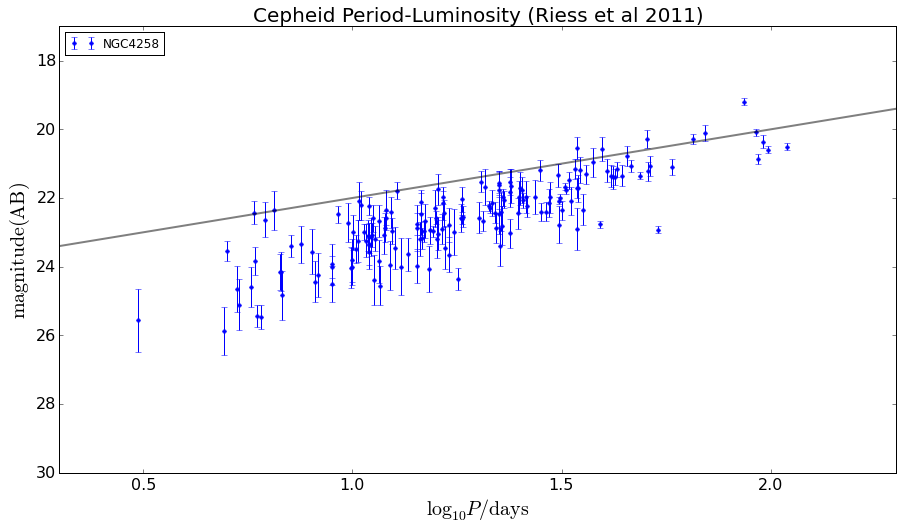

In [6]:
data.plot(4258)

# for ID in data.list_hosts():
#     data.plot(ID)
    
data.overlay_straight_line_with(a=-2.0,b=24.0)

data.add_legend()

####  Q: Is the Cepheid Period-Luminosity relation likely to be well-modeled by a power law ?

Is it easy to find straight lines that "fit" all the data from each host? And do we get the same "fit" for each host?

## Inferring the Period-Magnitude Relation

* Let's try inferring the parameters $a$ and $b$ of the following linear relation:

$m = a\;\log_{10} P + b$

* We have data consisting of *observed magnitudes with quoted uncertainties*, of the form 

$m^{\rm obs} = 24.51 \pm 0.31$ at $\log_{10} P = \log_{10} (13.0/{\rm days})$

* Let's draw a PGM for this, imagining our way  through what we would do to generate a mock dataset like the one we have.

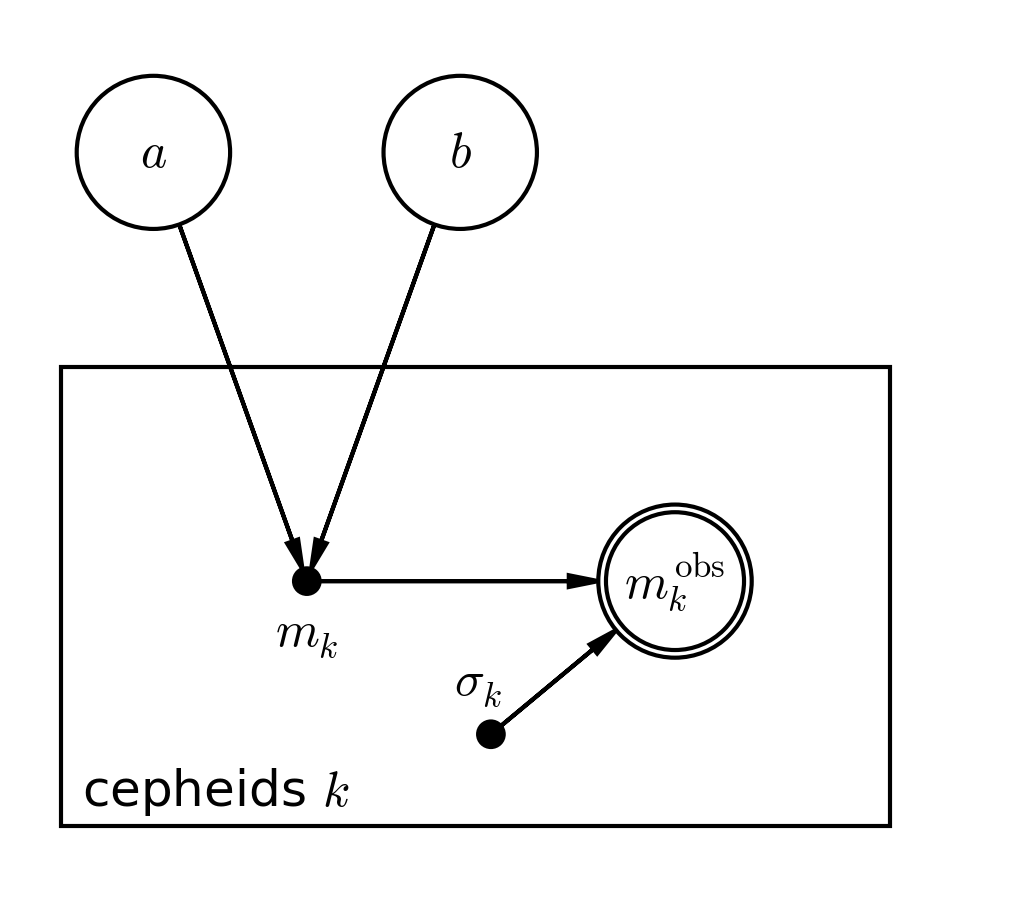

In [64]:
# import cepheids_pgm
# cepheids_pgm.simple()

from IPython.display import Image
Image(filename="cepheids_pgm.png")

### Q: What are reasonable assumptions about the sampling distribution for the $k^{\rm th}$ datapoint, ${\rm Pr}(m^{\rm obs}_k|m_k,H)$?

* We were given points ($m^{\rm obs}_k$) with error bars ($\sigma_k$), which suggests a *Gaussian* sampling distribution (as was suggested in Session 1):

${\rm Pr}(m^{\rm obs}_k|m_k,\sigma_k,H) = \frac{1}{Z} \exp{-\frac{(m^{\rm obs}_k - m_k)^2}{2\sigma_k^2}}$


* Then, we might suppose that the measurements of each Cepheid start are *independent* of each other, so that we can define *predicted and observed data vectors* $m$ and $m^{\rm obs}$ (plus a corresponding observational uncertainty vector $\sigma$) via:

${\rm Pr}(m^{\rm obs}|m,\sigma,H) = \prod_k {\rm Pr}(m^{\rm obs}_k|m_k,\sigma_k,H)$

### Q: What is the conditional PDF ${\rm Pr}(m_k|a,b,\log{P_k},H)$?

Our relationship between the intrinsic magnitude and the log period is linear and deterministic, indicating the following *delta-function* PDF:

${\rm Pr}(m_k|a,b,\log{P_k},H) = \delta(m_k - a\log{P_k} - b)$

### Q: What is the resulting joint likelihood, ${\rm Pr}(m^{\rm obs}|a,b,H)$?

* The factorisation of the joint PDF for everything inside the plate that is illustrated by the PGM is:

${\rm Pr}(m^{\rm obs}|m,\sigma,H)\;{\rm Pr}(m|a,b,H) = \prod_k {\rm Pr}(m^{\rm obs}_k|m_k,\sigma_k,H)\;\delta(m_k - a\log{P_k} - b)$

* The intrinsic magnitudes of each Cepheid ($m$) are not interesting, and so we marginalize them out:

${\rm Pr}(m^{\rm obs}|a,b,H) = \int {\rm Pr}(m^{\rm obs}|m,\sigma,H)\;{\rm Pr}(m|a,b,H)\; dm$

so that ${\rm Pr}(m^{\rm obs}|a,b,H) = \prod_k {\rm Pr}(m^{\rm obs}_k|[a\log{P_k} + b],\sigma,H)$

### Q: What is the log likelihood?

$\log {\rm Pr}(m^{\rm obs}|a,b,H) = \sum_k \log {\rm Pr}(m^{\rm obs}_k|[a\log{P_k} + b],\sigma,H)$

which, substituting in our Gaussian form, gives us: 

$\log {\rm Pr}(m^{\rm obs}|a,b,H) = {\rm constant} - 0.5 \sum_k \frac{(m^{\rm obs}_k - a\log{P_k} - b)^2}{\sigma_k^2}$

* This sum is often called $\chi^2$ ("chi-squared"), and you may have seen it before. It's an effective "misfit" statistic, quantifying the difference between observed and predicted data - and under the assumptions outlined here, it's twice the log likelihood (up to a constant).

### Q: What could be reasonable assumptions for the prior ${\rm Pr}(a,b|H)$?

For now, we can (continue to) assume a uniform distribution for each of $a$ and $b$ - in the homework, you can investigate some alternatives.

${\rm Pr}(a|H) = \frac{1.0}{a_{\rm max} - a_{\rm min}}\;\;{\rm for}\;\; a_{\rm min} < a < a_{\rm max}$


${\rm Pr}(b|H) = \frac{1.0}{b_{\rm max} - b_{\rm min}}\;\;{\rm for}\;\; b_{\rm min} < b < b_{\rm max}$

We should now be able to code up functions for the log likelihood, log prior and log posterior, such that we can evaluate them on a 2D parameter grid. Let's fill them in:

In [50]:
def log_likelihood(logP,mobs,merr,a,b):
    return -0.5*np.sum((mobs - a*logP -b)**2/(merr**2))

def log_prior(a,b):
    amin,amax = -10.0,10.0
    bmin,bmax = 10.0,30.0
    if (a > amin)*(a < amax)*(b > bmin)*(b < bmax):
        logp = np.log(1.0/(amax-amin)) + np.log(1.0/(bmax-bmin))
    else:
        logp = -np.inf
    return logp

def log_posterior(logP,mobs,merr,a,b):
    return log_likelihood(logP,mobs,merr,a,b) + log_prior(a,b)

Now, let's set up a suitable parameter grid and compute the posterior PDF!

In [51]:
# Select a Cepheid dataset:
data.select(4258)

# Set up parameter grids:
npix = 100
amin,amax = -4.0,-2.0
bmin,bmax = 25.0,27.0
agrid = np.linspace(amin,amax,npix)
bgrid = np.linspace(bmin,bmax,npix)
logprob = np.zeros([npix,npix])

# Loop over parameters, computing unnormlized log posterior PDF:
for i,a in enumerate(agrid):
    for j,b in enumerate(bgrid):
        logprob[j,i] = log_posterior(data.logP,data.mobs,data.merr,a,b)

# Normalize and exponentiate to get posterior density:
Z = np.max(logprob)
prob = np.exp(logprob - Z)
norm = np.sum(prob)
prob /= norm

Now, plot, with confidence contours:

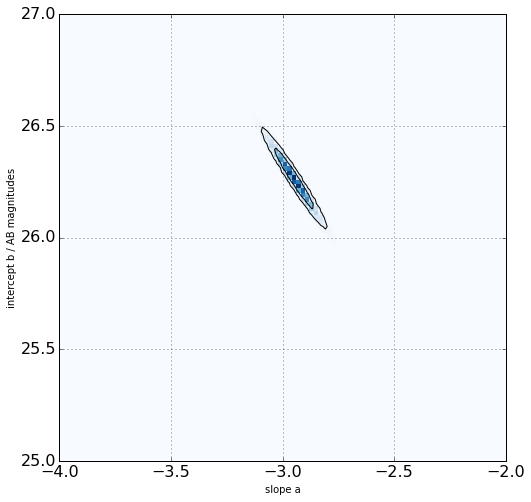

In [52]:
sorted = np.sort(prob.flatten())
C = sorted.cumsum()

# Find the pixel values that lie at the levels that contain
# 68% and 95% of the probability:
lvl68 = np.min(sorted[C > (1.0 - 0.68)])
lvl95 = np.min(sorted[C > (1.0 - 0.95)])

plt.imshow(prob, origin='lower', cmap='Blues', interpolation='none', extent=[amin,amax,bmin,bmax])
plt.contour(prob,[lvl68,lvl95],colors='black',extent=[amin,amax,bmin,bmax])
plt.grid()
plt.xlabel('slope a')
plt.ylabel('intercept b / AB magnitudes')

* Are these inferred parameters sensible? 


* Let's read off a plausible (a,b) pair and overlay the model period-magnitude relation on the data.

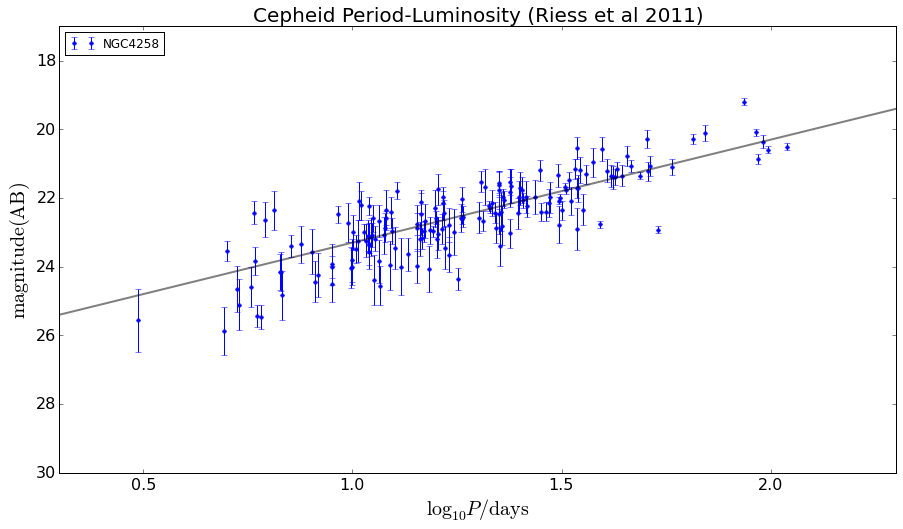

In [53]:
data.plot(4258)

data.overlay_straight_line_with(a=-3.0,b=26.3)

data.add_legend()

OK, this looks good! Later in the course we will do some more extensive *model checking*.

### Summarizing our Inferences

Let's compute the 1D marginalized posterior PDFs for $a$ and for $b$, and report the median and "68% credible interval" (defined as the region of 1D parameter space enclosing 68% of the posterior probability).

In [54]:
prob_a_given_data = np.sum(prob,axis=0) # Approximate the integral as a sum
prob_b_given_data = np.sum(prob,axis=1) # Approximate the integral as a sum

In [55]:
print(prob_a_given_data.shape, np.sum(prob_a_given_data))

(100,) 1.0


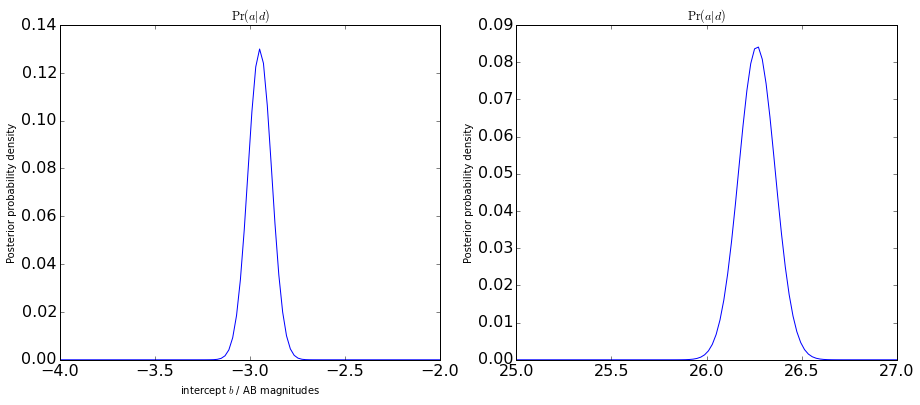

In [56]:
# Plot 1D distributions:

fig,ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
plt.subplots_adjust(wspace=0.2)

left = ax[0].plot(agrid, prob_a_given_data)
ax[0].set_title('${\\rm Pr}(a|d)$')
ax[0].set_xlabel('slope $a$')
ax[0].set_ylabel('Posterior probability density')

right = ax[1].plot(bgrid, prob_b_given_data)
ax[1].set_title('${\\rm Pr}(a|d)$')
ax[0].set_xlabel('intercept $b$ / AB magnitudes')
ax[1].set_ylabel('Posterior probability density')

In [57]:
# Compress each PDF into a median and 68% credible interval, and report:

def compress_1D_pdf(x,pr,ci=68,dp=1):
    
    # Interpret credible interval request:
    low  = (1.0 - ci/100.0)/2.0    # 0.16 for ci=68
    high = 1.0 - low               # 0.84 for ci=68

    # Find cumulative distribution and compute percentiles:
    cumulant = pr.cumsum()
    pctlow = x[cumulant>low].min()
    median = x[cumulant>0.50].min()
    pcthigh = x[cumulant>high].min()
    
    # Convert to error bars, and format a string:
    errplus = np.abs(pcthigh - median)
    errminus = np.abs(median - pctlow)
    
    report = "$ "+str(round(median,dp))+"^{+"+str(round(errplus,dp))+"}_{-"+str(round(errminus,dp))+"} $"
    
    return report

In [58]:
print("a = ",compress_1D_pdf(agrid,prob_a_given_data,ci=68,dp=2))

print("b = ",compress_1D_pdf(bgrid,prob_b_given_data,ci=68,dp=2))

a =  $ -2.95^{+0.06}_{-0.06} $
b =  $ 26.27^{+0.08}_{-0.1} $


### Notes

* In this simple case, our report makes sense: the medians of both 1D marginalized PDFs lie within the region of high 2D posterior PDF. *This will not always be the case.*


* The marginalized posterior for $x$ has a well-defined meaning, regardless of the higher dimensional structure of the joint posterior:  it is ${\rm Pr}(x|d,H)$, the PDF for $x$ given the data and the model, and *accounting for the uncertainty in all other parameters*.


* The high degree of symmetry in this problem is due to the posterior being a *bivariate Gaussian.* We could have derived the posterior PDF *analytically* - but in general this will not be possible. The homework invites you to explore various other analytic and numerical possibilities in this simple inference scenario.